# Trajectory optimization for the double integrator

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from pydrake.common import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    MathematicalProgram,
    Solve,
    eq,
)

from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import BasicVector, LeafSystem
from pydrake.trajectories import PiecewisePolynomial

import numpy as np
# Create a grid of points
num_points = 4  # number of points in each dimension
num_scales = 5  # number of scales we shrink
scales = np.logspace(0, num_scales, num=num_scales, base=0.25, endpoint=False)
print(scales)
x_grid = np.linspace(-1, 1, num_points) 
y_grid = np.linspace(-1, 1, num_points) 
N=500

LoadData = True

ImportError: cannot import name 'getDrakePath' from 'pydrake' (unknown location)


## Direct Collocation

With only a minor change, we can use `DirectCollocation` instead of `DirectTranscription`.  This works directly on the continuous-time equations, but even though the system is linear, it gives a nonconvex optimization (make sure you understand why!). Satisfyingly, though, this finds the optimal solution (the true minimum time) without needing a line search!

In [ ]:
def dircol_example(x0, fig, ax, N):
    ## Build LTI System
    A = np.mat(".2 1; 0 0")    
    B = np.mat("0; 1")
    C = np.eye(2)
    D = np.zeros((2, 1))
    sys = LinearSystem(A, B, C, D)

    result_success = False

    while not result_success:

        # x0 = [xi, yi]
        xf = [0, 0]

        dircol = DirectCollocation(
            system=sys,
            context=sys.CreateDefaultContext(),
            num_time_samples=N,
            minimum_time_step=0.001,
            maximum_time_step=10 / N,
        )
        
        prog = dircol.prog()
        prog.AddBoundingBoxConstraint(x0, x0, dircol.initial_state())
        prog.AddBoundingBoxConstraint(xf, xf, dircol.final_state())
        dircol.AddConstraintToAllKnotPoints(dircol.input()[0] <= 1)
        dircol.AddConstraintToAllKnotPoints(dircol.input()[0] >= -1)
        dircol.AddEqualTimeIntervalsConstraints()
        # dircol.AddRunningCost("u**2")
        R = 10  # Cost on input "effort".
        u = dircol.input()
        dircol.AddRunningCost(R * u[0] ** 2)

        dircol.AddFinalCost(dircol.time())

        result = Solve(prog)
        assert result.is_success(), "Optimization failed"
        result_success = result.is_success
        N= 2* N


    u_sol = dircol.ReconstructInputTrajectory(result)
    x_sol = dircol.ReconstructStateTrajectory(result)
    print(f"minimum time = {dircol.GetSampleTimes(result)[-1]}")

    x_values = x_sol.vector_values(x_sol.get_segment_times())
    ax.plot(x_values[0, :], x_values[1, :], "k-")

    u_values = u_sol.vector_values(u_sol.get_segment_times())
    # ax[1].plot(u_sol.get_segment_times(), u_values.T, ".-")

    t_values = [np.array(u_sol.get_segment_times())]
    # ax.show()

    return x_values, u_values, t_values


if not LoadData:
    fig, ax = plt.subplots(1, 1)
    fig.tight_layout(pad=2.0)

    X= np.empty((0,N))
    U= np.empty((0,N))
    T= np.empty((0,N))

    for scale in scales:
        for xi in x_grid:
            for yi in y_grid:
                x0=[xi*scale,yi*scale]

                if (abs(xi)==1) or (abs(yi)==1):
                    print("x0=", x0)

                    x, u, t = dircol_example(x0, fig, ax, N)

                    X = np.concatenate((X,x), axis = 0)
                    U = np.concatenate((U,u), axis = 0)
                    T = np.concatenate((T,t), axis = 0)

            

    ax.set_xlabel("$p$")
    ax.set_ylabel("$q$")
    ax.set_aspect("equal")

    # ax[0].set_xlabel("q")
    # ax[0].set_ylabel("qdot")

    # ax[1].set_xlabel("t")
    # ax[1].set_ylabel("u")

    # plt.xlim(-2, 2)
    # plt.ylim(-2, 2)
    plt.show()


Note that there is a sample in the middle of the solution with u = 0.  Do you understand why?  (Hint: trying changing `N`)

### Saving Examples

In [ ]:
import pickle

if not LoadData:
    db = { "X" : X , "U": U , "T" : T }
    pickle.dump( db, open( "db.p", "wb" ) )


### Loading Examples

In [ ]:
import pickle 

if LoadData:
    ## Build Controler
    db = pickle.load( open( "db.p", "rb" ) )

    X=db.get("X")
    U=db.get("U")
    T=db.get("T")


Text(0, 0.5, '$\\dot q$')

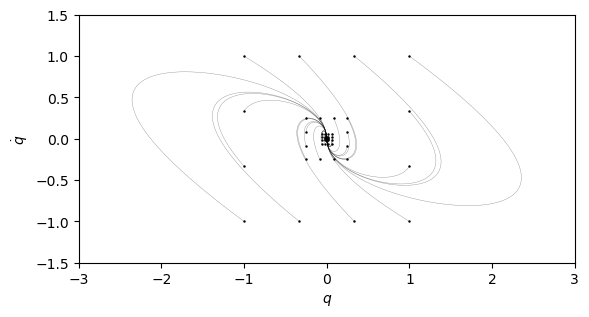

In [ ]:
plt.figure()

m,n = X.shape

for i in range(0,round(m/2),1):
    plt.plot(X[2*i],X[2*i+1],'k-', alpha = 0.5, linewidth = .25)
    plt.plot(X[2*i,0],X[2*i+1,0],'k.', alpha = 1, markersize = 1.5)
    plt.xlim([-3,3])
    plt.ylim([-1.5,1.5])
    # plt.gca().set_aspect(2/3)
ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlabel("$q$")
ax.set_ylabel("$\dot q$")



# Chain Policies

## Define a Chain Policy Class

In [ ]:
class ChainPolicy(LeafSystem):
    def __init__(self, X, U):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("u", BasicVector(2))
        self.DeclareVectorOutputPort("y", BasicVector(1), self.CalcOutputY)
        self.X=X
        self.U=U

    def CalcOutputY(self, context, output):
        x = self.get_input_port().Eval(context)
        y, xref = self.FindClosest(x)
        # print("Value calculated is:", y)
        # print("What is output:", output )
        output.SetFromVector([y])

    # We allow this function to input an n by m input vector x
    def FindClosest(self, x):
        X = self.X
        U = self.U

        #It is critical to serialize X correctly.        
        n, m = X.shape

        x1 = np.reshape(X[:n:2],(1,-1))
        x2 = np.reshape(X[1:n:2],(1,-1))
        Xserial = np.vstack((x1,x2))
        # Xserial = np.reshape(X,(2,-1))


        Userial = np.reshape(U,(1,-1))
        
        #store x's shape
        # n, m = x.shape        

        x = np.reshape(x,(2,-1))
 
        # print(Xserial.shape)
        # print(Userial.shape)

        # a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        distances = np.linalg.norm(Xserial-x, axis=0)
        index = np.argmin(distances)


        return np.array(Userial[0,index]), np.array([[Xserial[0,index]],[Xserial[1,index]]])


### Illustrate Policy

Here we show what is the outcome of the policy.

[1.]


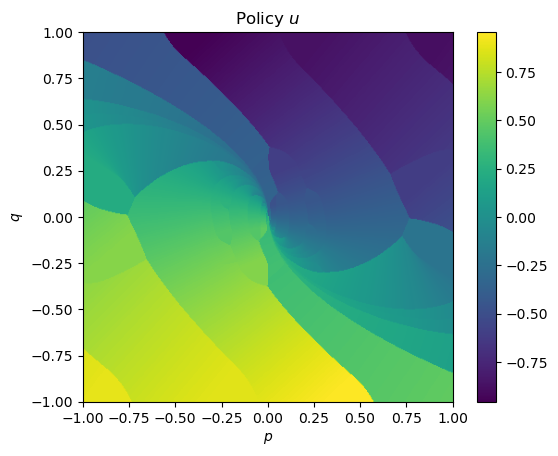

In [ ]:
def show_policy(scale):

    policy = ChainPolicy(X, U)
    plt.figure()

    # Define the range for x1 and x2
    x1 = np.arange(-1*scale, 1*scale, 0.005*scale)
    x2 = np.arange(-1*scale, 1*scale, 0.005*scale)
    X1, X2 = np.meshgrid(x1, x2)

    # Initialize Z to store the policy output
    Z = np.zeros(X1.shape)

    # Evaluate the policy for each point in the grid
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j], _ = policy.FindClosest(np.array([X1[i, j], X2[i, j]]))

    

    # Visualize the policy using imshow
    plt.imshow(Z, extent=(-1*scale, 1*scale, -1*scale, 1*scale), origin='lower')
    plt.colorbar()
    plt.title('Policy $u$')
    plt.xlabel('$p$')
    plt.ylabel('$q$')

 

scales = np.logspace(0, 1, 1, base=0.25, endpoint=False)
print(scales)
for scale in scales:
    show_policy(scale)


## Interconnect Systems

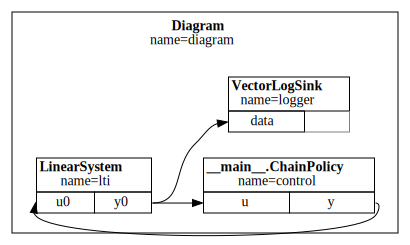

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.all import LinearSystem, LeafSystem
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

## Build LTI System
A = np.mat(".2 1; 0 0")    
B = np.mat("0; 1")
C = np.eye(2)
D = np.zeros((2, 1))
sys = LinearSystem(A, B, C, D)

lti = builder.AddNamedSystem("lti", sys)



# ## Build Controler
# db = pickle.load( open( "db.p", "rb" ) )

# X=db.get("X")
# U=db.get("U")
# T=db.get("T")

# Constructing my policy
policy = ChainPolicy(X,U)

# u, x=policy.FindClosest([1,1])
# print(u)

# port = policy.get_output_port
# print(type(port))

controller = builder.AddNamedSystem("control", policy)


# Now. we connect them

builder.Connect(lti.get_output_port(), controller.get_input_port())
builder.Connect(controller.get_output_port(), lti.get_input_port())



# Log LTI system state
logger = LogVectorOutput(lti.get_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the diagram.
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

## It is time to simulate

We are now ready to test our policy!!

In [ ]:
#Set the main conext
context = diagram.CreateDefaultContext()

xs = context.get_mutable_continuous_state_vector()
xs.SetFromVector([-.7, -.9])
xs.SetFromVector([-.5,1.85])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)

# dt=0.1
# for n in range(0,np.int16(N/2)):
#     # print(n/N)
#     simulator.AdvanceTo(n*dt)

simulator.AdvanceTo(80)

# Plot the results.
log = logger.FindLog(context)


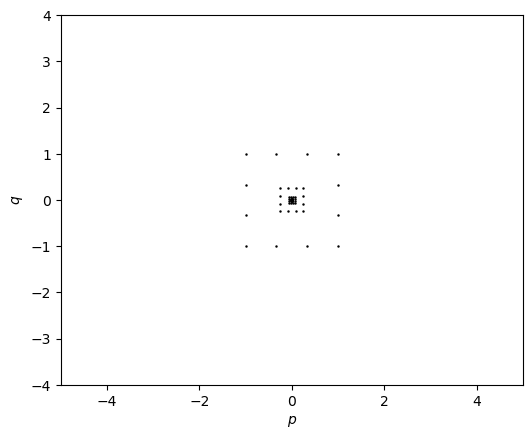

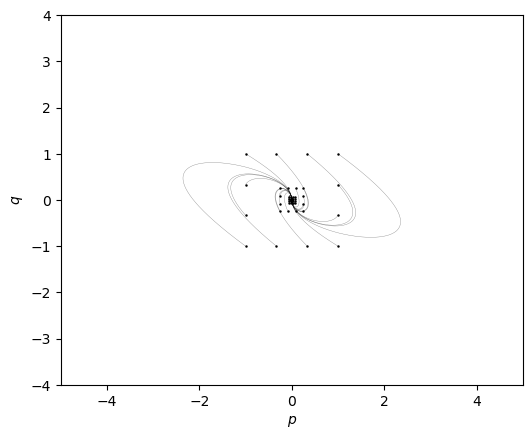

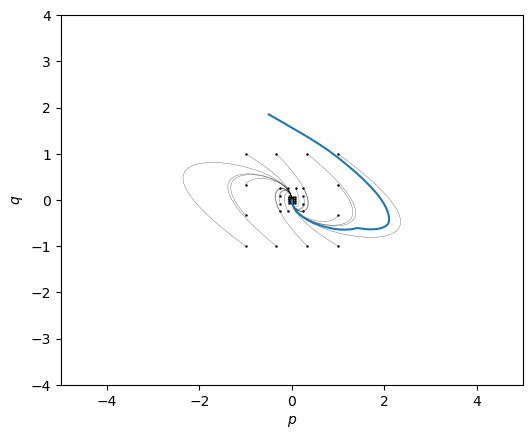

In [ ]:


m,n = X.shape
scale = 2
x_lim = [-2.5*scale,2.5*scale]
y_lim = [-2*scale,2*scale]

plt.figure()
for i in range(0,round(m/2),1):
    # plt.plot(X[2*i],X[2*i+1],'k-', alpha = 0.5, linewidth = .25)
    plt.plot(X[2*i,0],X[2*i+1,0],'k.', alpha = 1, markersize = 1.5)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    # plt.gca().set_aspect(2/3)
    plt.gca().set_aspect("equal")
    plt.xlabel('$p$')
    plt.ylabel('$q$')



plt.figure()
for i in range(0,round(m/2),1):
    plt.plot(X[2*i],X[2*i+1],'k-', alpha = 0.5, linewidth = .25)
    plt.plot(X[2*i,0],X[2*i+1,0],'k.', alpha = 1, markersize = 1.5)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    # plt.gca().set_aspect(2/3)
    plt.gca().set_aspect("equal")
    plt.xlabel('$p$')
    plt.ylabel('$q$')


plt.figure()
for i in range(0,round(m/2),1):
    plt.plot(X[2*i],X[2*i+1],'k-', alpha = 0.5, linewidth = .25)
    plt.plot(X[2*i,0],X[2*i+1,0],'k.', alpha = 1, markersize = 1.5)
    plt.plot(X[2*i],X[2*i+1],'k-', alpha = 0.25, linewidth = .25)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.gca().set_aspect('equal')
    plt.xlabel('$p$')
    plt.ylabel('$q$')


plt.plot(log.data()[0],log.data()[1])

# plt.figure()


2 33112
[1.91637679e+00 1.91623881e+00 1.91554908e+00 ... 7.11747006e-04
 6.98875423e-04 7.02652028e-04]
(2, 33112)


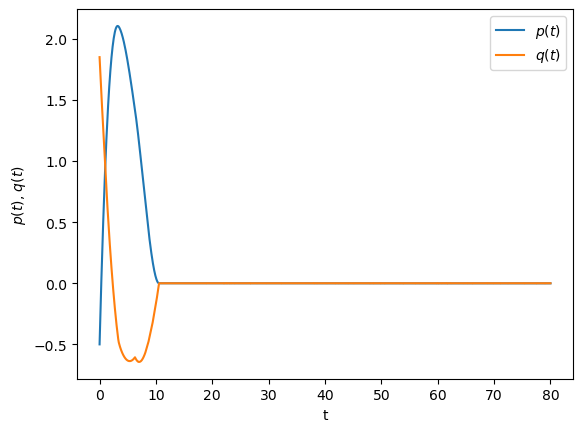

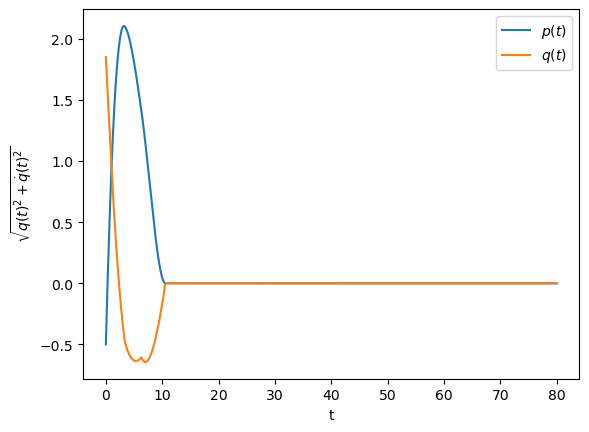

In [ ]:

# Plot the results.
log = logger.FindLog(context)

plt.figure()
plt.plot(log.sample_times(), log.data().transpose(),label=["$p(t)$","$q(t)$"])
plt.xlabel('t')
plt.ylabel('$p(t)$, $q(t)$');
plt.legend()
# plt.ylim([-.25, .25])


n, m = log.data().shape

print(n,m)

data = log.data()

# n, m = data.shape
# print(n,m)
# print(data.transpose()[0])
# u = data[0]*0
# for i in range(0,m):
#     u_aux, x_aux=policy.FindClosest(data.transpose()[i])
#     u[i] = u_aux    

# plt.figure()
# plt.plot(log.sample_times(),u.transpose())



print(np.linalg.norm(log.data(), axis=0))

print(log.data().shape)

plt.figure()
plt.plot(log.sample_times(), log.data().transpose(), label=["$p(t)$", "$q(t)$"])
plt.xlabel('t')
plt.ylabel('$\sqrt{q(t)^2 + \dot q(t)^2}$');
plt.legend()
# plt.savefig('./figures/' + file_prefix + '-test-x0-{}-norm.png'.format(x0))

In [ ]:
import numpy as np
x1=np.array([1, 2 ,3])
x2=np.array([4, 5, 4])

x3 = np.array([x1, x2])

# n,m = x3.shape

# print([n,m])

x4 = np.empty((2,0))
x4 = np.concatenate((x4, x3),axis=1)
x4 = np.concatenate((x4, x3),axis=1)
# x4  = [x3, x1]

print(x4)


x = []
x.append(x1)
print(x)
x.append(x2)
print(x)

# xs = np.empty([1,0])
# print(xs)
# print(x[0])
xs = []
xs = np.concatenate((xs, x[0]), axis=0)
print(xs)
xs = np.concatenate((xs, x[1]), axis=0)
print(xs)

[[1. 2. 3. 1. 2. 3.]
 [4. 5. 4. 4. 5. 4.]]
[array([1, 2, 3])]
[array([1, 2, 3]), array([4, 5, 4])]
[1. 2. 3.]
[1. 2. 3. 4. 5. 4.]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2d0ab38a-4cf9-4dc2-a595-6716c6ec5e79' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>